<a href="https://colab.research.google.com/github/daria-sazon/portfolio-project-1_sales-analytics/blob/main/Portfolio_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Підключення до BigQuery та бібліотек

!pip install --upgrade google-cloud-bigquery

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Аутенфікація
auth.authenticate_user()

# Створення клієнта BigQuery
client = bigquery.Client(project="data-analytics-mate")

## **Data overview**

In [3]:
# SQL запит для створення датасету

query = """
SELECT
  s.date AS order_date,
  s.ga_session_id AS session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name AS traffic_source,
  sp.channel,
  acs.account_id,
  ac.is_verified,
  ac.is_unsubscribed,
  p.category AS product_category,
  p.name AS product_name,
  p.price AS product_price,
  p.short_description

  FROM `DA.session` s
  LEFT JOIN `DA.session_params` sp ON s.ga_session_id = sp.ga_session_id
  LEFT JOIN `DA.account_session` acs ON sp.ga_session_id = acs.ga_session_id
  LEFT JOIN `DA.account` ac ON acs.account_id = ac.id
  LEFT JOIN `DA.order` o ON sp.ga_session_id = o.ga_session_id
  LEFT JOIN `DA.product` p ON o.item_id = p.item_id
"""

query_job = client.query(query)  # Виконання SQL-запиту
results = query_job.result()  # Очікування завершення запиту

df = results.to_dataframe()
df.head()

,order_date,session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,channel,account_id,is_verified,is_unsubscribed,product_category,product_name,product_price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         349545 non-null  dbdate 
 1   session_id         349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  product_category   33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [5]:
# Загальна кількість колонок
print(f"Загальна кількість колонок: {df.shape[1]}\n")

# Кількість колонок числового типу (та які саме)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Кількість колонок числового типу: {len(numeric_cols)}\n"
      f"Назви колонок числового типу: {numeric_cols}\n")

# Кількість колонок категоріального типу (та які саме)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Кількість колонок категоріального типу: {len(categorical_cols)}\n"
      f"Назви колонок категоріального типу: {categorical_cols}\n")

# Kількість колонок типу datetime
datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()
print(f"Кількість колонок типу datetime: {len(datetime_cols)}\n"
      f"Назви колонок типу datetime: {datetime_cols}\n")

# Kількість унікальних сесій
print(f"Kількість унікальних сесій: {df.session_id.nunique()}")

# Який період часу розглядається (від… до…)
start_date = df.order_date.min()
end_date = df.order_date.max()
print(f"Період часу: від {start_date} до {end_date}\n")

# Чи є пропущені значення
print(f"Пропущенні значення:\n{df.isna().sum()}\n")

# Доля пропусків даних, %
print(f"Доля пропусків даних, %:\n{df.isna().sum() / df.shape[0] * 100}\n")

# B яких колонках більше пропущених значень
missing_values = df.isna().sum().sort_values(ascending=False).head(5)
print(f"Колонки, в яких більше пропущених значень:\n{missing_values}\n")

print(f"Така кількість пропущених значень повʼязана із тим, що зареєстрованих користувачів небагато,\nале нас цікавлять усі замовлення та усі сесії, навіть якщо користувач не зареєструвався на сайті.")

Загальна кількість колонок: 18

Кількість колонок числового типу: 5
Назви колонок числового типу: ['session_id', 'account_id', 'is_verified', 'is_unsubscribed', 'product_price']

Кількість колонок категоріального типу: 12
Назви колонок категоріального типу: ['continent', 'country', 'device', 'browser', 'mobile_model_name', 'operating_system', 'language', 'traffic_source', 'channel', 'product_category', 'product_name', 'short_description']

Кількість колонок типу datetime: 0
Назви колонок типу datetime: []

Kількість унікальних сесій: 349545
Період часу: від 2020-11-01 до 2021-01-31

Пропущенні значення:
order_date                0
session_id                0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
traffic_source            0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      3216

### **Короткий опис отриманого датасету**

* Загальна кількість колонок: ***18***.
* Кількість колонок числового типу: ***5***.
* Назви колонок числового типу: ***session_id, account_id, is_verified, is_unsubscribed, product_price***.
* Кількість колонок категоріального типу: ***12***.
* Назви колонок категоріального типу: ***continent, country, device, browser, mobile_model_name, operating_system, language, traffic_source, channel, product_category, product_name, short_description***.
* Кількість колонок типу datetime: ***1***.
* Назви колонок типу datetime: ***order_date***.
* Kількість унікальних сесій: ***349545***.
* Період часу: від ***2020-11-01 00:00:00*** до ***2021-01-31 00:00:00***.


Пропущені значення (доля у %):
* 92% — ***account_id, is_verified, is_unsubscribed***,
* 90% — ***product_category, product_name, product_price, short_description***,
* 32% — ***language***.

Причини такої кількості пропущених значень повʼязана із тим, що зареєстрованих користувачів небагато, але нас цікавлять усі замовлення та усі сесії, навіть якщо користувач не зареєструвався на сайті або немає замовлення товару. По мові така кількість пропущених значень говорить, що можлива системна причина, наприклад, поле не заповнюється автоматично або мова не визначається для певних користувачів.

## **Data cleaning**

In [6]:
# Перетворення типу даних для колонки order_date
df["order_date"] = pd.to_datetime(df["order_date"])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   order_date         349545 non-null  datetime64[ns]
 1   session_id         349545 non-null  Int64         
 2   continent          349545 non-null  object        
 3   country            349545 non-null  object        
 4   device             349545 non-null  object        
 5   browser            349545 non-null  object        
 6   mobile_model_name  349545 non-null  object        
 7   operating_system   349545 non-null  object        
 8   language           235279 non-null  object        
 9   traffic_source     349545 non-null  object        
 10  channel            349545 non-null  object        
 11  account_id         27945 non-null   Int64         
 12  is_verified        27945 non-null   Int64         
 13  is_unsubscribed    27945 non-null   Int64   

In [8]:
# Перевірка пропущених даних перед заміною
missing_rows = df[df.isna().any(axis=1)]
print(missing_rows)

       order_date  session_id continent         country   device  browser  \
0      2020-11-01  5760483956  Americas   United States  desktop   Chrome   
1      2020-11-01  7115337200    Europe  United Kingdom  desktop   Chrome   
2      2020-11-01  3978035233    Europe          Norway   mobile   Chrome   
3      2020-11-01  9648986282    Africa         Nigeria   mobile   Chrome   
4      2020-11-01  4393441533      Asia           China  desktop   Chrome   
...           ...         ...       ...             ...      ...      ...   
349540 2021-01-31  5756982967    Europe         Ukraine  desktop  Firefox   
349541 2021-01-31   464560636  Americas   United States  desktop     Edge   
349542 2021-01-31  6336117447  Americas   United States  desktop   Chrome   
349543 2021-01-31  4958826563      Asia           India   mobile   Safari   
349544 2021-01-31  7058940865    Europe          Norway  desktop     Edge   

       mobile_model_name operating_system language  traffic_source  \
0    

In [9]:
# Коригування пропущених значень в колонках категоріального типу, заміняємо на "Unknown"
df["product_category"] = df["product_category"].fillna("Unknown")
df["product_name"] = df["product_name"].fillna("Unknown")
df["product_price"] = df["product_price"].fillna("Unknown")
df["short_description"] = df["short_description"].fillna("Unknown")
df["language"] = df["language"].fillna("Unknown")
df["continent"] = df["continent"].replace("(not set)", "Unknown")

In [10]:
# Перетворення усіх нечислових значень на NaN:
df["product_price"] = pd.to_numeric(df["product_price"], errors="coerce")

In [11]:
# Перевірка кількості пропусків в даних після коригування
print(df.isna().sum())

order_date                0
session_id                0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language                  0
traffic_source            0
channel                   0
account_id           321600
is_verified          321600
is_unsubscribed      321600
product_category          0
product_name              0
product_price        316007
short_description         0
dtype: int64


In [12]:
# Перевірка дублікатів
duplicate_rows_events = df.duplicated()
print(duplicate_rows_events)
print(duplicate_rows_events.sum())

0         False
1         False
2         False
3         False
4         False
          ...  
349540    False
349541    False
349542    False
349543    False
349544    False
Length: 349545, dtype: bool
0


## **Data analysis and visualization**

### **Топ-3 континента, в яких компанія має найбільші продажі та найбільшу кількість замовлень**

In [59]:
pd.options.display.float_format = "{:,.0f}$".format

print(f"Топ-3 континента по продажах, $:\n{df.groupby("continent")["product_price"].sum().nlargest(3)}\n")
print(f"Топ-3 континента по кількості замовлень:\n{df.groupby("continent")["product_price"].count().nlargest(3)}")

Топ-3 континента по продажах, $:
continent
Americas   17,665,280$
Asia        7,601,298$
Europe      5,934,624$
Name: product_price, dtype: float64

Топ-3 континента по кількості замовлень:
continent
Americas    18553
Asia         7950
Europe       6261
Name: product_price, dtype: int64


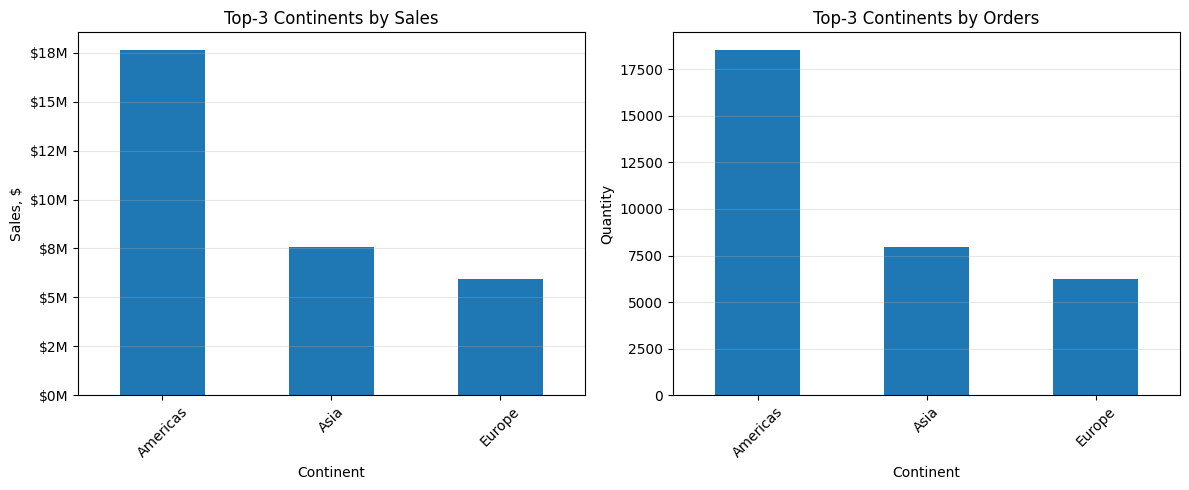

In [56]:
# Знаходимо континенти з найбільшими показниками
total_sales_continent = df.groupby("continent")["product_price"].sum().sort_values(ascending=False).head(3)
total_orders_continent = df.groupby("continent")["product_price"].count().sort_values(ascending=False).head(3)

# Будуємо візуалізації
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1 = total_sales_continent.plot(kind='bar', ax = ax1, legend=False)
ax1.set_title("Top-3 Continents by Sales")
ax1.set_ylabel("Sales, $")
ax1.set_xlabel("Continent")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M")) # Формат осі Y у доларах
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

ax2 = total_orders_continent.plot(kind='bar', ax = ax2, legend=False)
ax2.set_title("Top-3 Continents by Orders")
ax2.set_ylabel("Quantity")
ax2.set_xlabel("Continent")
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### **Топ-10 країн, в яких компанія має найбільші продажі та найбільшу кількість замовлень**

In [57]:
print(f"Топ-10 країн по продажах:\n{df.groupby("country")["product_price"].sum().nlargest(10)}\n")
print(f"Топ-10 країн по кількості замовлень:\n{df.groupby("country")["product_price"].count().nlargest(10)}")

Топ-10 країн по продажах:
country
United States    13,943,554$
India             2,809,762$
Canada            2,437,921$
United Kingdom      938,318$
France              710,693$
Spain               631,547$
Germany             599,221$
China               588,330$
Taiwan              552,710$
Singapore           456,447$
Name: product_price, dtype: float64

Топ-10 країн по кількості замовлень:
country
United States     14673
India              3029
Canada             2560
United Kingdom     1029
France              678
Spain               658
Germany             642
China               600
Taiwan              564
Japan               454
Name: product_price, dtype: int64


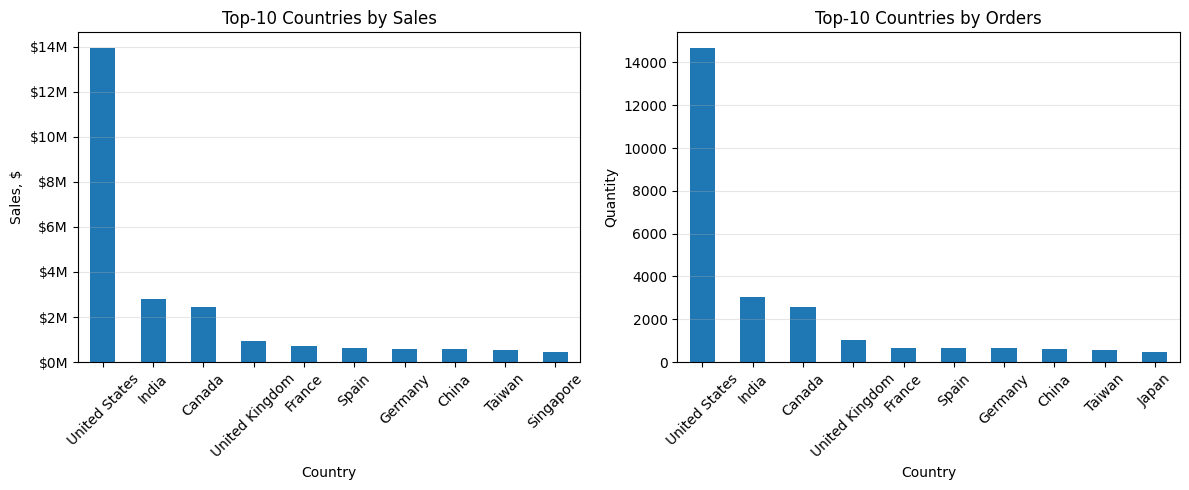

In [16]:
# Знаходимо країни з найбільшими показниками
total_sales_country = df.groupby("country")["product_price"].sum().sort_values(ascending=False).head(10)
total_orders_country = df.groupby("country")["product_price"].count().sort_values(ascending=False).head(10)


# Будуємо візуалізації
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

ax1 = total_sales_country.plot(kind='bar', ax = ax1, legend=False)
ax1.set_title("Top-10 Countries by Sales")
ax1.set_ylabel("Sales, $")
ax1.set_xlabel("Country")
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M")) # Формат осі Y у доларах
ax1.grid(axis='y', alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

ax2 = total_orders_country.plot(kind='bar', ax = ax2, legend=False)
ax2.set_title("Top-10 Countries by Orders")
ax2.set_ylabel("Quantity")
ax2.set_xlabel("Country")
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### **Топ-10 категорій товарів за загальною сумою продажів по всім країнам**

In [61]:
print(f"Топ-10 категорій товарів за загальною сумою продажів, $:\n{df.groupby("product_category")["product_price"].sum().nlargest(10)}\n")

Топ-10 категорій товарів за загальною сумою продажів, $:
product_category
Sofas & armchairs                  8,388,254$
Chairs                             6,147,749$
Beds                               4,919,725$
Bookcases & shelving units         3,640,818$
Cabinets & cupboards               2,336,500$
Outdoor furniture                  2,142,222$
Tables & desks                     1,790,308$
Chests of drawers & drawer units     906,562$
Bar furniture                        735,503$
Children's furniture                 467,697$
Name: product_price, dtype: float64



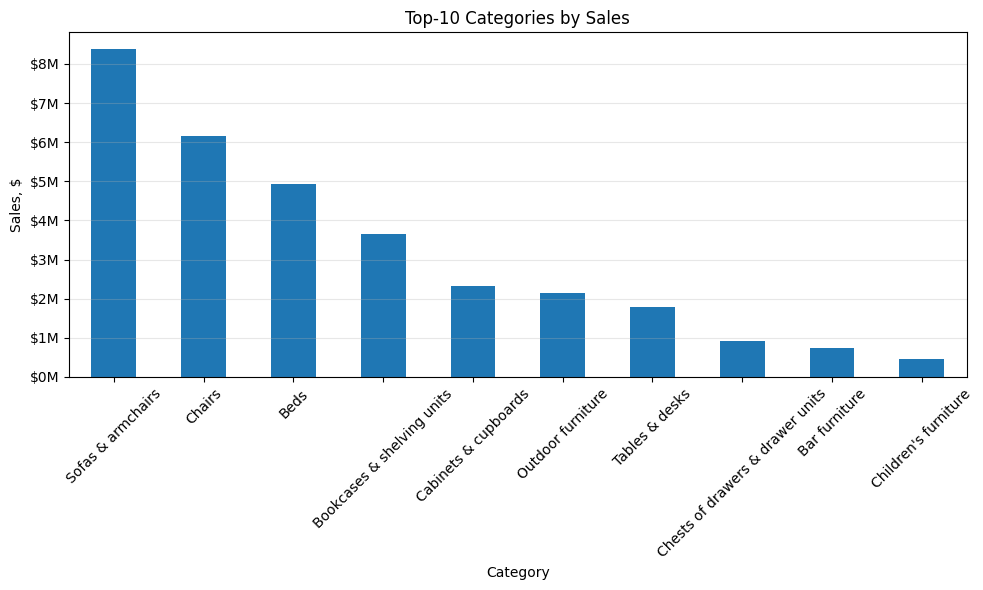

In [62]:
# Знаходимо топ-10 категорій по продажах
total_sales_category = df.groupby("product_category")["product_price"].sum().sort_values(ascending=False).head(10)

# Побудова графіка
plt.figure(figsize=(10, 6))

total_sales_category.plot(kind="bar", legend=False)
plt.title("Top-10 Categories by Sales")
plt.xlabel("Category")
plt.ylabel("Sales, $")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M")) # Формат осі Y у доларах
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

### **Топ-10 категорій товарів у країні з найбільшими продажами**

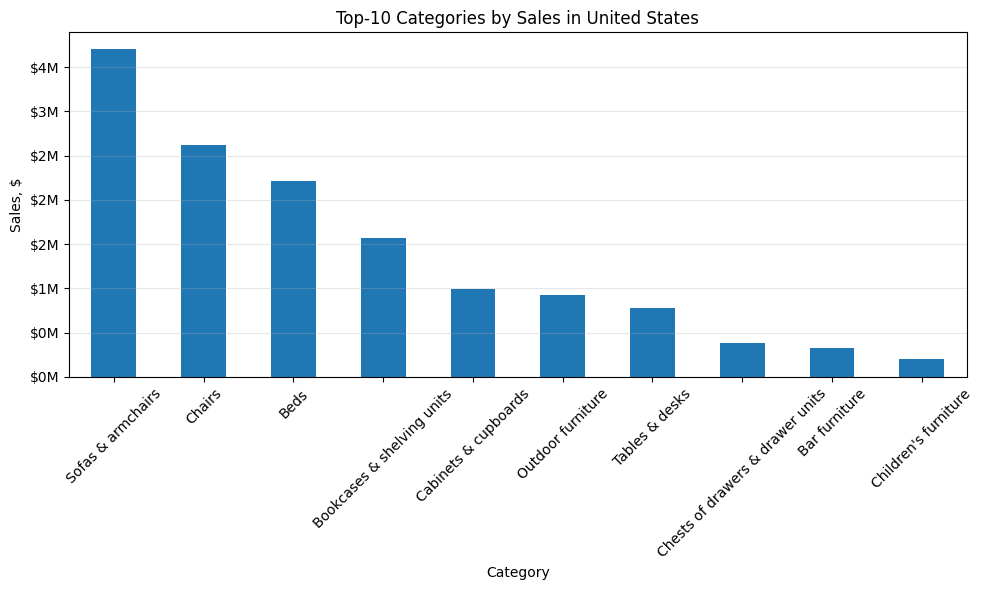

In [63]:
# Знаходимо країну з найбільшими продажами
top_country_sales = df.groupby("country")["product_price"].sum().sort_values(ascending=False).head(1)
top_country_name = top_country_sales.index[0]

# Фільтруємо датафрейм за цією країною
top_country_df = df[df["country"] == top_country_name]

# Топ-10 категорій за продажами у цій країні
top_country_categories = top_country_df.groupby("product_category")["product_price"].sum().sort_values(ascending=False).head(10)

# Побудова графіка
plt.figure(figsize=(10, 6))
top_country_categories.plot(kind="bar", legend=False)
plt.title(f"Top-10 Categories by Sales in {top_country_name}")
plt.xlabel("Category")
plt.ylabel("Sales, $")
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e6:.0f}M"))
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


In [20]:
print(f"Топ-10 категорій товарів в {top_country_name}:\n{top_country_categories}")

Топ-10 категорій товарів в United States:
product_category
Sofas & armchairs                  3,707,144$
Chairs                             2,619,774$
Beds                               2,213,058$
Bookcases & shelving units         1,567,607$
Cabinets & cupboards                 994,546$
Outdoor furniture                    929,245$
Tables & desks                       777,865$
Chests of drawers & drawer units     382,388$
Bar furniture                        330,805$
Children's furniture                 207,575$
Name: product_price, dtype: float64


**Висновки:**

Проаналізувавши результати топ-10 категорій товарів за загальною сумою продажів по всім країнам та топ-10 категорій товарів у країні з найбільшими продажами, ми бачимо, що популярність категорій не відрізняються та мають однаковий попит.

### **Аналіз продажів у розрізі типів девайсів**

In [21]:
print(f"Продажі у розрізі типів девайсів:\n{df.groupby("device")["product_price"].sum()}")

Продажі у розрізі типів девайсів:
device
desktop   18,864,039$
mobile    12,384,226$
tablet       723,466$
Name: product_price, dtype: float64


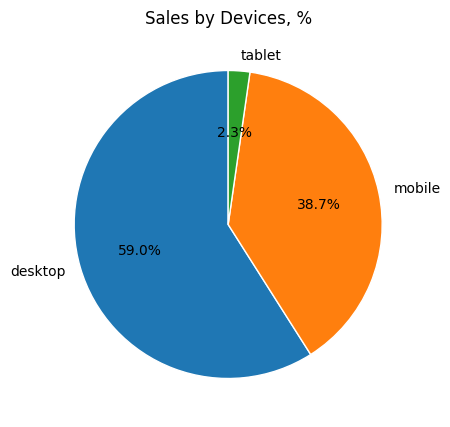

In [22]:
# Рахуємо продажі по девайсам
sales_by_device = df.groupby("device")["product_price"].sum()

# Будуємо візуалізацію
plt.figure(figsize = (5, 5))
plt.pie(
    sales_by_device,
    labels=sales_by_device.index,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Sales by Devices, %")
plt.show()

### **Аналіз продажів у розрізі браузерів**

In [23]:
print(f"Продажі у розрізі браузерів:\n{df.groupby("browser")["product_price"].sum().sort_values(ascending = False)}")

Продажі у розрізі браузерів:
browser
Chrome            21,826,850$
Safari             7,526,544$
<Other>              923,355$
Edge                 716,444$
Firefox              567,524$
Android Webview      411,014$
Name: product_price, dtype: float64


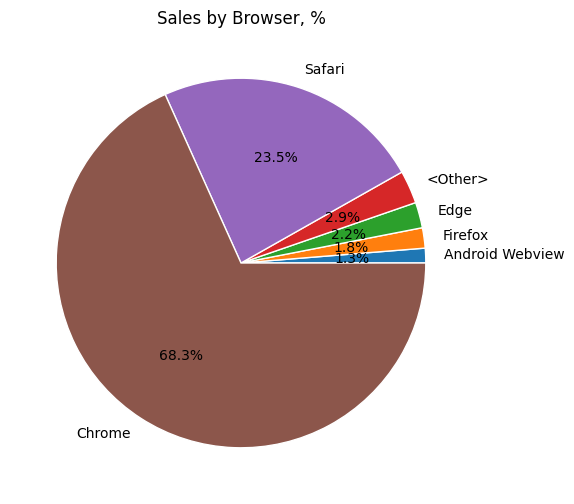

In [24]:
# Рахуємо продажі по типу браузера
sales_by_browser = df.groupby("browser")["product_price"].sum().sort_values()

# Переводимо продажі у %
sales_by_browser_percent = (sales_by_browser / sales_by_browser.sum()) * 100

# Будуємо візуалізацію
plt.figure(figsize = (6, 6))
plt.pie(
    sales_by_browser,
    labels=sales_by_browser.index,
    autopct='%1.1f%%',
    wedgeprops={"edgecolor": "white"}
)

plt.title("Sales by Browser, %")
plt.show()

### **Аналіз продажів у розрізі моделей девайсів**

In [66]:
print(f"Продажі у розрізі типів моделей девайсів:\n{df.groupby("mobile_model_name")["product_price"].sum().sort_values(ascending = False)}")

Продажі у розрізі типів моделей девайсів:
mobile_model_name
Chrome       8,899,524$
<Other>      6,535,331$
Safari       6,491,062$
iPhone       6,420,776$
ChromeBook   1,830,459$
Edge           697,222$
iPad           448,854$
Firefox        421,067$
Pixel 4 XL     118,288$
Pixel 3        109,148$
Name: product_price, dtype: float64


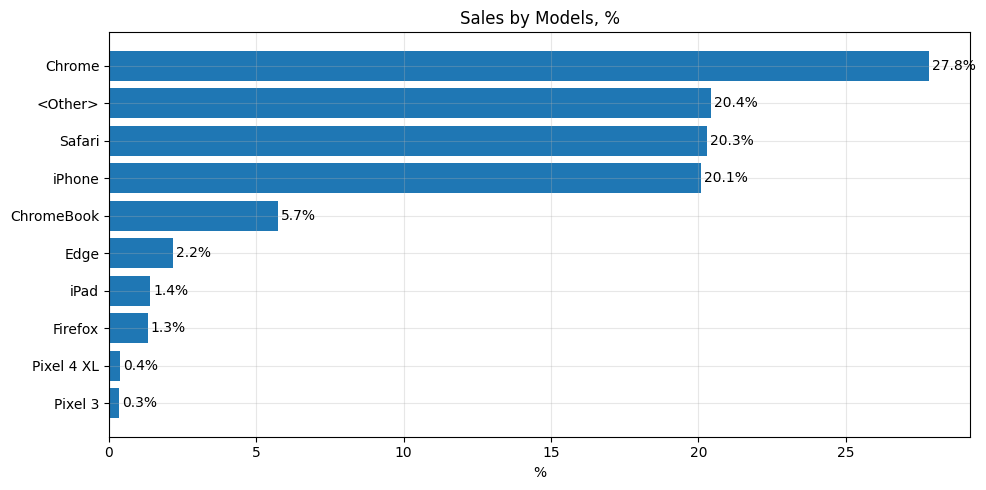

In [65]:
# Рахуємо продажі по типу моделі девайса
sales_by_model = df.groupby("mobile_model_name")["product_price"].sum().sort_values()

# Переводимо продажі у %
sales_by_models_percent = (sales_by_model / sales_by_model.sum()) * 100

# Будуємо візуалізацію
plt.figure(figsize = (10, 5))
bars = plt.barh(sales_by_models_percent.index, sales_by_models_percent.values)
plt.title("Sales by Models, %")
plt.xlabel("%")
for bar in bars:
  plt.text(
      bar.get_width() + 0.1,
      bar.get_y() + bar.get_height() / 2,
      f"{bar.get_width():.1f}%",
      va='center'
  )

plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

**Висновки:**

У розрізі типів девайсів лідирують компʼютери (**desktop**) — 59%, мобільні пристрої на другому місці (**mobile**) та мають частку 38.7%, найменші показники у планшетів (**tablet**) — 2.3%

В браузерах лідирує **Chrome** — 68.3%, далі йде **Safari** — 23.5%, найменша частка у **Firefox** та **Android Webview** < 1.5%

По типу моделей на першому місці **Chrome** — 27.8%, далі майже однакову частку у розмірі 20% мають **Safari**, **iPhone** та **Other**. Найменші показники мають **iPad, Firefox, Pixel 4XL, Pixel 3** — їх частка менша 1.5%

### **Аналіз продажів за джерелами трафіку**

In [27]:
print(f"Продажі за джерелами трафіку:\n{df.groupby("channel")["product_price"].sum().sort_values(ascending = False)}")

Продажі за джерелами трафіку:
channel
Organic Search   11,433,152$
Paid Search       8,511,049$
Direct            7,494,923$
Social Search     2,532,106$
Undefined         2,000,501$
Name: product_price, dtype: float64


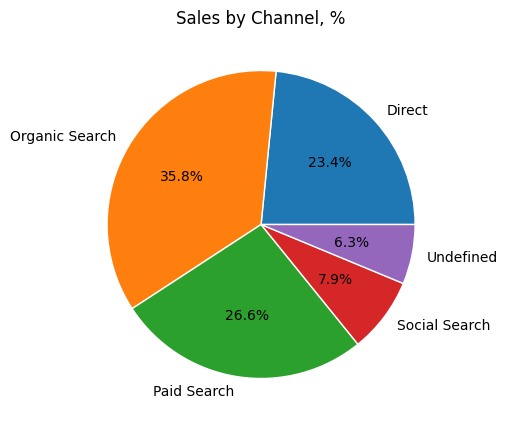

In [68]:
# Рахуємо продажі по джерелам трафіку
sales_by_channel = df.groupby("channel")["product_price"].sum()

# Будуємо візуалізацію
plt.figure(figsize = (5, 5))
plt.pie(
    sales_by_channel,
    labels=sales_by_channel.index,
    autopct='%1.1f%%',
    wedgeprops={'edgecolor': 'white'}
)

plt.title("Sales by Channel, %")
plt.show()

**Висновки:**

Найбільші продажі по джерелу трафіка дає **Organic Search** — 34.2%. Далі йдуть **Paid Search** (26.6%) та **Direct** (23.4%).

Найменші показники мають **Social Search** (7.9%) та **Undefined** (6.3%)

### **Аналіз поведінки користувачів**

In [29]:
print(f"Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: {((df["is_verified"] == 1).sum() / df["account_id"].count() * 100).round(1)}%")
print(f"Відсоток користувачів, які відписалися від розсилки: {((df["is_unsubscribed"] == 1).sum() / df["account_id"].count() * 100).round(1)}%")

Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу: 71.7%
Відсоток користувачів, які відписалися від розсилки: 16.9%


In [30]:
print(f"Продажі по підписаним на розсилку користувачам: {df[df["is_unsubscribed"] == 0]["product_price"].sum()}$")
print(f"Продажі по відписаним на розсилку користувачам: {df[df["is_unsubscribed"] == 1]["product_price"].sum()}$")

Продажі по підписаним на розсилку користувачам: 2150796.9$
Продажі по відписаним на розсилку користувачам: 431721.6$


In [31]:
# Знаходимо топ-10 країн по реєстраціям
accounts_by_country = df.groupby("country")["account_id"].count().sort_values(ascending=False).head(10)

print(f"Топ-10 країн за зареєстрованими користувачами:\n{accounts_by_country}")

Топ-10 країн за зареєстрованими користувачами:
country
United States     12384
India              2687
Canada             2067
United Kingdom      859
France              553
Spain               536
Taiwan              500
China               490
Germany             490
Italy               386
Name: account_id, dtype: Int64


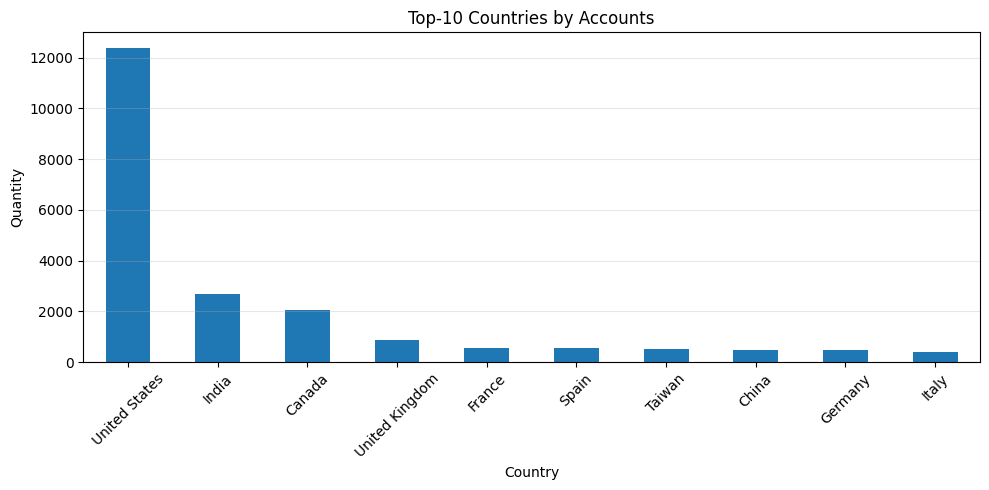

In [70]:
# Побудова графіка
plt.figure(figsize=(10, 5))

accounts_by_country.plot(kind="bar", legend=False)
plt.title("Top-10 Countries by Accounts")
plt.xlabel("Country")
plt.ylabel("Quantity")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

**Висновки:**

Відсоток зареєстрованих користувачів, які підтвердили свою електронну адресу складає **71.7%**

Відсоток зареєстрованих користувачів, які відписалися від розсилки склав **16.9%**

Поведінка (у плані продажів) тих, хто відписався від розсилки та тих, хто досі підписаний відрізняється майже у 5 разів на користь тих, хто підписаний.

Загальні продажі:
* підписані на розсилку — **2 150 797$**

* відписані від розсилки — **431 722$**

Найбільше зареєстрованих користувачів у **United States** (12384), **India** (2687) та **Canada** (2067).


### **Аналіз динаміки продажів**

**Загальні продажі та продажі за кожну дату**

In [33]:
df["sales"] = df["product_price"]
total_sales = df["sales"].sum().round()
total_sales_by_date = df.groupby("order_date")["product_price"].sum().round()

print(f"Загальні продажі компанії:\n{total_sales:,}$\n")
print(f"Загальні продажі за кожну дату:\n{total_sales_by_date}$")

Загальні продажі компанії:
31,971,731.0$

Загальні продажі за кожну дату:
order_date
2020-11-01   244,292$
2020-11-02   355,507$
2020-11-03   498,980$
2020-11-04   339,187$
2020-11-05   391,277$
               ...   
2021-01-27   286,341$
2021-01-28         0$
2021-01-29         0$
2021-01-30         0$
2021-01-31         0$
Name: product_price, Length: 92, dtype: float64$


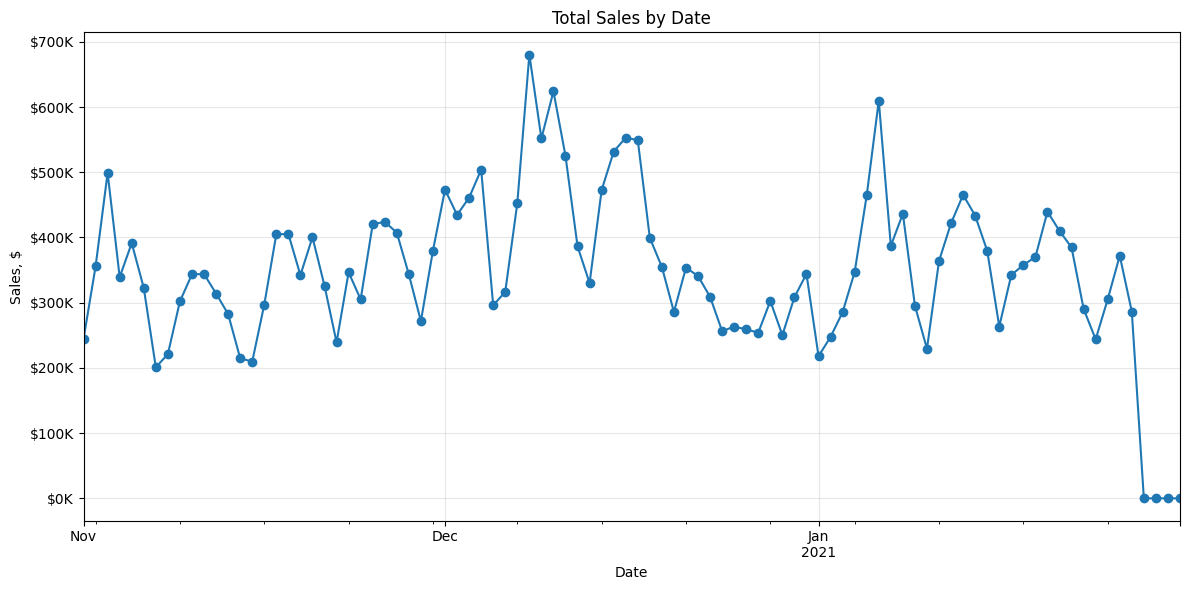

In [72]:
# Візуалізація динаміки загальних продажів за кожну дату
plt.figure(figsize=(12, 6))

total_sales_by_date.plot(kind="line", marker="o")
plt.title("Total Sales by Date")
plt.xlabel("Date")
plt.ylabel("Sales, $")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e3:.0f}K"))
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Загальні ппродажі компанії у розрізі днів тримаються в діпозоні **200-500 тис.дол.**

Пік продажів спостерігається на початку грудня до **700 тис.дол.** та на початку січня до **600 тис.дол.**, що свідчить про сезонність в святковий період.

**Динаміка продажів в Америці, Азії та Європі**

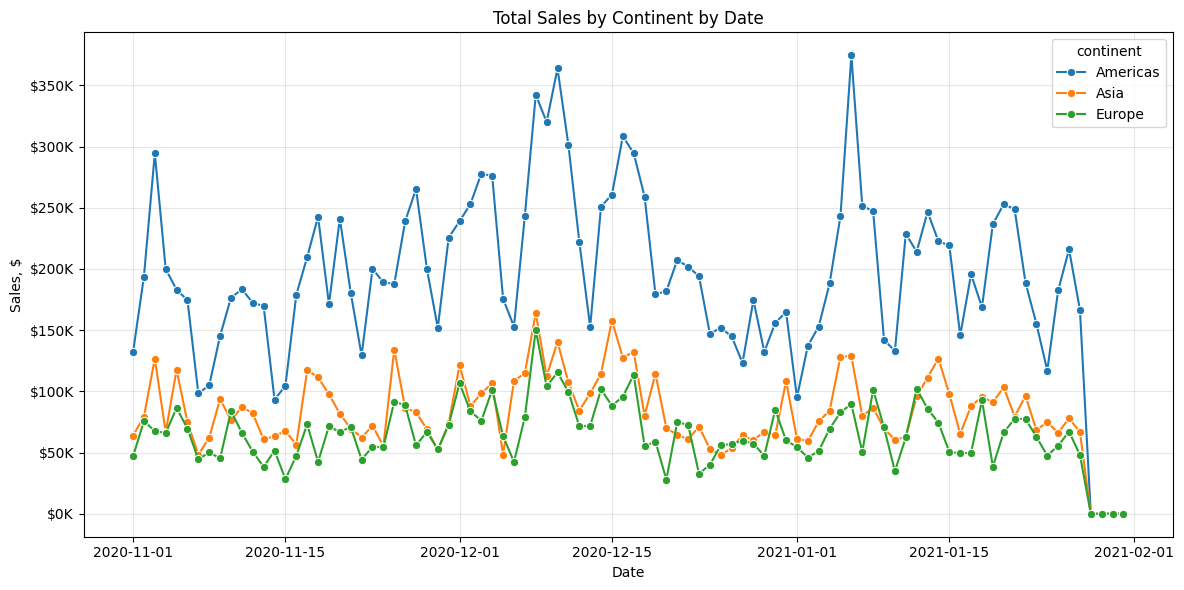

In [73]:
# Обираємо 3 континенти
continents = ["Americas", "Asia", "Europe"]
filter_for_continents = df[df["continent"].isin(continents)]
sales_by_date_continents = filter_for_continents.groupby(["order_date", "continent"])["product_price"].sum().reset_index()

# Візуалізація динаміки
plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_by_date_continents, x="order_date", y="product_price", hue="continent", marker="o")
plt.title("Total Sales by Continent by Date")
plt.xlabel("Date")
plt.ylabel("Sales, $")
plt.grid(alpha=0.3)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e3:.0f}K"))

plt.tight_layout()
plt.show()

**Висновки:**

У розрізі континентів лідером є **Америка**, що демонструє найвищі обсяги продажів у діапозоні 100-300 тис.дол., із сезонними піками до 350 тис.дол. на початку грудня та січня.

Продажі в **Азії** та **Європі** в межах 40-130 тис.дол., з незначними сезонними піками до 150 тис.дол. у той самий період, що й в Америці.

**Аналіз динаміки продажів у розрізі каналів трафіку**

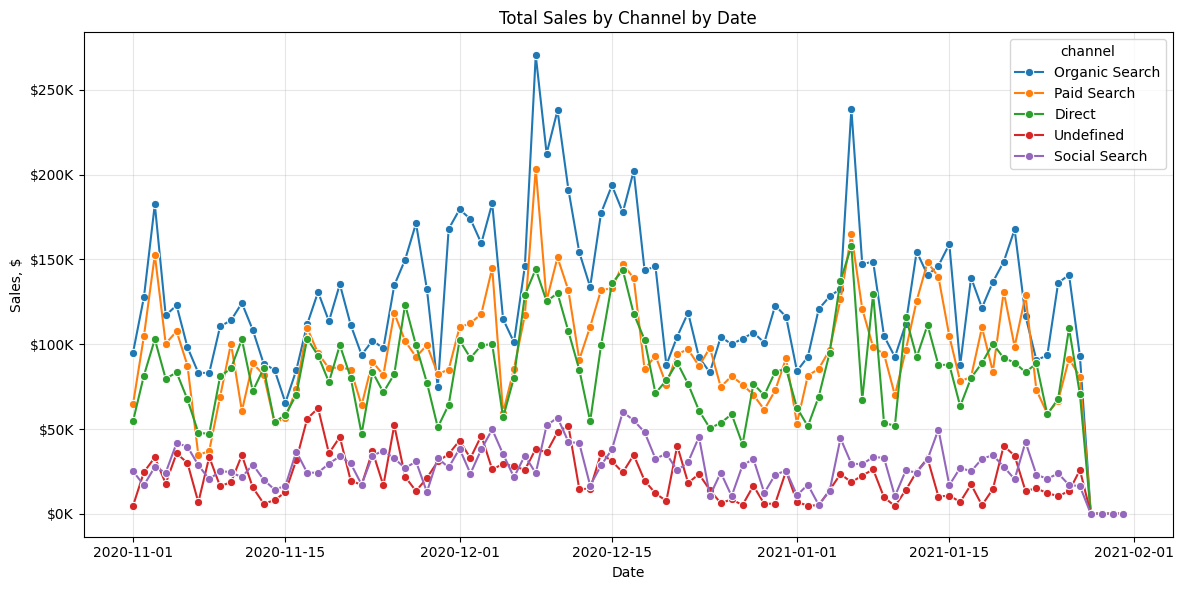

In [74]:
sales_by_channel = df.groupby(["order_date", "channel"])["product_price"].sum().sort_values(ascending=False).reset_index()

# Візуалізація динаміки
plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_by_channel, x="order_date", y="product_price", hue="channel", marker="o")
plt.title("Total Sales by Channel by Date")
plt.xlabel("Date")
plt.ylabel("Sales, $")
plt.grid(alpha=0.3)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e3:.0f}K"))

plt.tight_layout()
plt.show()

**Висновки:**

У розрізі каналів продажів лідером є **Organic Search**, який демонструє стабільно високі показники — у межах 80–170 тис. дол., з піками до +250 тис. дол. на початку грудня та січня.

Канали **Paid Search** та **Direct** посідають друге й третє місця з обсягами 50–120 тис. дол., показуючи схожу сезонну динаміку.

**Social Search** та **Undefined** мають найнижчі продажі — до 50 тис. дол., без виражених сезонних коливань.

**Аналіз динаміки продажів у розрізі типів девайсів**

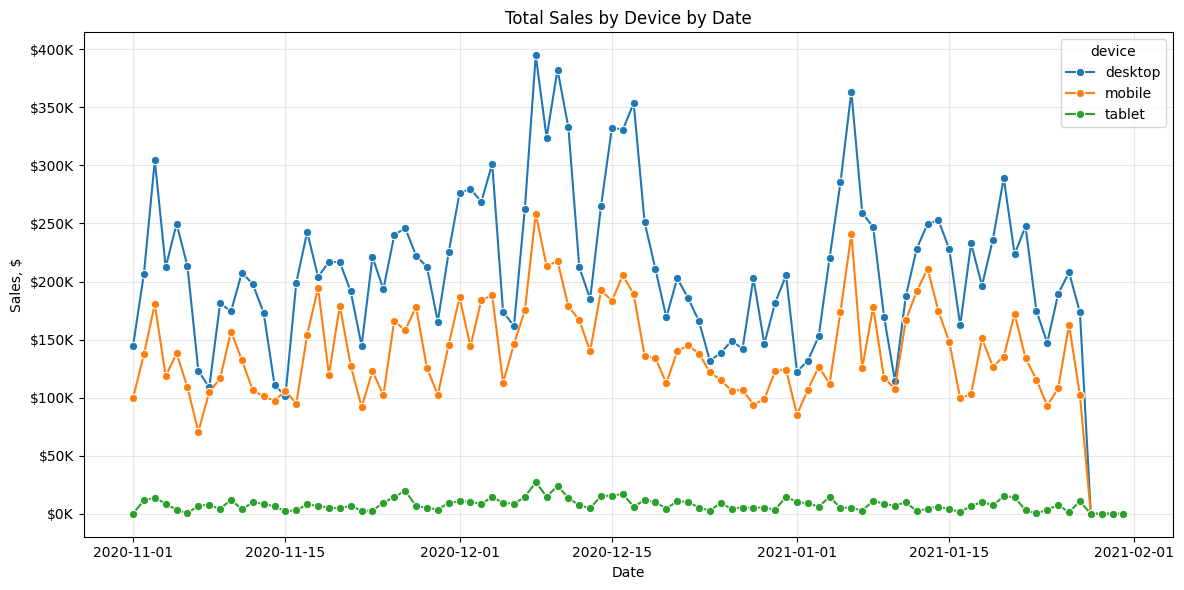

In [75]:
sales_by_device = df.groupby(["order_date", "device"])["product_price"].sum().reset_index()

# Візуалізація динаміки
plt.figure(figsize=(12, 6))

sns.lineplot(data=sales_by_device, x="order_date", y="product_price", hue="device", marker="o")
plt.title("Total Sales by Device by Date")
plt.xlabel("Date")
plt.ylabel("Sales, $")
plt.grid(alpha=0.3)
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e3:.0f}K"))

plt.tight_layout()
plt.show()

**Висновки:**

У розрізі пристроїв основний обсяг продажів припадає на комп’ютери (**desktop**) — у діапазоні 150-300 тис. дол., із піками до 400 тис. дол. на початку грудня та січня.

Мобільні пристрої (**mobile**) займають другу позицію з продажами 100-200 тис. дол., демонструючи аналогічну сезонність.

Планшети (**tablet**) мають найменшу частку — менше 30 тис. дол. упродовж усього періоду, без виражених сезонних коливань.

## **Pivot Table**

**Загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)**

In [38]:
top_category = df.groupby("product_category")["product_price"].sum().nlargest(10).index
top_country = df.groupby("country")["product_price"].sum().nlargest(5).index

pivot = (
    df[df["product_category"].isin(top_category) & df["country"].isin(top_country)]
    .pivot_table(
    index = "product_category",
    columns = "country",
    values = "product_price",
    aggfunc = "sum"
    )
)

print(pivot)

country                            Canada   France    India  United Kingdom  \
product_category                                                              
Bar furniture                     51,724$  11,199$  57,657$         22,103$   
Beds                             354,772$ 116,414$ 358,320$        133,816$   
Bookcases & shelving units       278,982$  73,830$ 364,507$        113,988$   
Cabinets & cupboards             181,802$  59,102$ 191,888$         71,684$   
Chairs                           417,741$ 134,029$ 544,309$        188,519$   
Chests of drawers & drawer units  71,952$  21,544$  73,111$         36,784$   
Children's furniture              30,264$  14,258$  39,177$         13,348$   
Outdoor furniture                185,323$  40,486$ 162,289$         57,002$   
Sofas & armchairs                692,428$ 187,735$ 788,430$        234,812$   
Tables & desks                   132,678$  42,299$ 186,158$         49,374$   

country                           United States  
p

**Кількість замовлень за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)**

In [39]:
pivot = (
    df[df["product_category"].isin(top_category) & df["country"].isin(top_country)]
    .pivot_table(
    index = "product_category",
    columns = "country",
    values = "product_price",
    aggfunc = "count"
    )
)

print(pivot)

country                           Canada  France  India  United Kingdom  \
product_category                                                          
Bar furniture                         83      17     96              34   
Beds                                 218      56    236              97   
Bookcases & shelving units           591     144    734             232   
Cabinets & cupboards                 184      51    201              77   
Chairs                               450     116    539             177   
Chests of drawers & drawer units     113      32    129              55   
Children's furniture                 116      46    142              42   
Outdoor furniture                    177      38    183              65   
Sofas & armchairs                    331      91    396             137   
Tables & desks                       219      60    287              82   

country                           United States  
product_category                                 

**Загальні продажі за категоріями товарів (топ-10) у різних континетах (топ-3)**

In [40]:
top_continent = df.groupby("continent")["product_price"].sum().nlargest(3).index

pivot = (
    df[df["product_category"].isin(top_category) & df["continent"].isin(top_continent)]
    .pivot_table (
    index = "product_category",
    columns = "continent",
    values = "product_price",
    aggfunc = "sum"
    )
)

print(pivot)

continent                          Americas       Asia     Europe
product_category                                                 
Bar furniture                      406,198$   176,684$   131,110$
Beds                             2,773,094$ 1,077,326$   925,048$
Bookcases & shelving units       1,968,919$   945,369$   650,890$
Cabinets & cupboards             1,275,562$   545,370$   468,652$
Chairs                           3,309,203$ 1,524,601$ 1,178,581$
Chests of drawers & drawer units   484,290$   210,384$   186,793$
Children's furniture               253,435$   112,389$    93,479$
Outdoor furniture                1,213,115$   488,608$   399,553$
Sofas & armchairs                4,737,307$ 1,950,022$ 1,491,224$
Tables & desks                     968,129$   464,192$   307,045$


**Кількість замовлень за категоріями товарів (топ-10) у різних континентах (топ-3)**


In [41]:
pivot = (
    df[df["product_category"].isin(top_category) & df["continent"].isin(top_continent)]
    .pivot_table (
    index = "product_category",
    columns = "continent",
    values = "product_price",
    aggfunc = "count"
    )
)

print(pivot)

continent                         Americas  Asia  Europe
product_category                                        
Bar furniture                          606   264     195
Beds                                  1645   659     548
Bookcases & shelving units            4231  1894    1345
Cabinets & cupboards                  1271   529     462
Chairs                                3296  1419    1107
Chests of drawers & drawer units       777   348     290
Children's furniture                   944   397     324
Outdoor furniture                     1252   514     410
Sofas & armchairs                     2403  1002     803
Tables & desks                        1573   710     572


**Кількість сесій у розрізі каналів трафіку та типів девайсів**

In [42]:
pivot = df.pivot_table (
    index = "channel",
    columns = "device",
    values = "session_id",
    aggfunc = "count"
)

print(pivot)

device          desktop  mobile  tablet
channel                                
Direct            47825   31745    1812
Organic Search    72622   49014    2789
Paid Search       55167   37034    2140
Social Search     16288   10988     638
Undefined         12527    8486     470


## **Statistical analysis**

**Статистичний аналіз взаємозвʼязків між кількістю сесій та загальними продажами за кожну дату**

In [43]:
# Кількість сесій і загальні продажі для кожної дати

daily_stats = df.groupby("order_date").agg (
    sessions = ("session_id", "nunique"),
    sales = ("product_price", "sum")
).reset_index()

print(f"{daily_stats}")

   order_date  sessions    sales
0  2020-11-01      2576 244,292$
1  2020-11-02      3599 355,507$
2  2020-11-03      5173 498,980$
3  2020-11-04      4184 339,187$
4  2020-11-05      3743 391,277$
..        ...       ...      ...
87 2021-01-27      4435 286,341$
88 2021-01-28      4112       0$
89 2021-01-29      3700       0$
90 2021-01-30      2845       0$
91 2021-01-31      2812       0$

[92 rows x 3 columns]


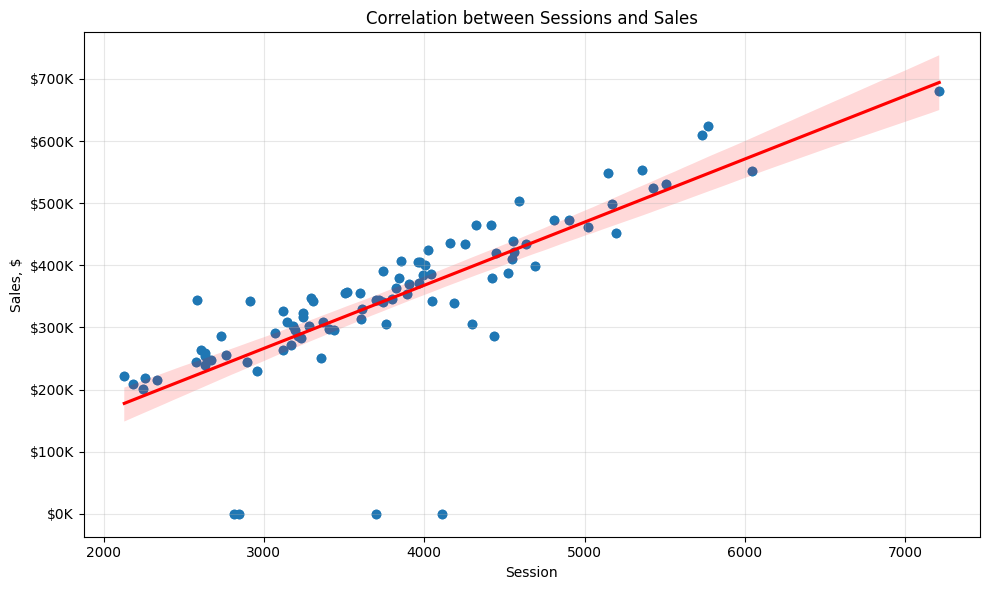

In [44]:
# Будуємо візуалізацію
plt.figure(figsize=(10, 6))

plt.scatter(daily_stats["sessions"], daily_stats["sales"])
sns.regplot(data=daily_stats, x="sessions", y="sales", line_kws={"color": "red"})
plt.title("Correlation between Sessions and Sales")
plt.xlabel("Session")
plt.ylabel("Sales, $")
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"${x/1e3:.0f}K"))

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [45]:
from scipy.stats import pearsonr

r, p_value = pearsonr(daily_stats["sessions"], daily_stats["sales"])
print(f"""Коефіцієнт кореляції (r): {r:.2f}
P-value: {p_value:.3f}""")

Коефіцієнт кореляції (r): 0.79
P-value: 0.000


**Висновки:**

Між кількістю сесій та загальними продажами спостерігається сильна позитивна статистично значуща кореляція (r = 0.79, p < 0.05). Це свідчить про те, що збільшення трафіку напряму пов’язане зі зростанням продажів.

**Кореляція продажів між континентами (топ-3)**

In [46]:
# Загальні продажі по континентах
top_continents = df.groupby("continent")["product_price"].sum().nlargest(3).index

top_continents_stats = (
    df[df["continent"].isin(top_continents)]
    .groupby(["order_date", "continent"])["product_price"].sum()
    .unstack(fill_value=0)
)

print(f"Продажі по континентах:\n{top_continents_stats}")

Продажі по континентах:
continent   Americas     Asia  Europe
order_date                           
2020-11-01  132,002$  63,823$ 46,908$
2020-11-02  193,861$  79,370$ 75,711$
2020-11-03  294,530$ 126,738$ 67,692$
2020-11-04  200,010$  66,602$ 65,915$
2020-11-05  182,988$ 117,608$ 86,540$
...              ...      ...     ...
2021-01-27  166,736$  66,783$ 48,156$
2021-01-28        0$       0$      0$
2021-01-29        0$       0$      0$
2021-01-30        0$       0$      0$
2021-01-31        0$       0$      0$

[92 rows x 3 columns]


In [47]:
# Americas vs. Asia

r, p_value = pearsonr(top_continents_stats["Americas"], top_continents_stats["Asia"])
print(f"""Кореляція Americas vs. Asia:
Коефіцієнт кореляції (r): {r:.2f}
P-value: {p_value:.3f}""")

Кореляція Americas vs. Asia:
Коефіцієнт кореляції (r): 0.79
P-value: 0.000


In [48]:
# Americas vs. Europe

r, p_value = pearsonr(top_continents_stats["Americas"], top_continents_stats["Europe"])
print(f"""Кореляція Americas vs. Europe:
Коефіцієнт кореляції (r): {r:.2f}
P-value: {p_value:.3f}""")

Кореляція Americas vs. Europe:
Коефіцієнт кореляції (r): 0.77
P-value: 0.000


In [49]:
# Asia vs. Europe

r, p_value = pearsonr(top_continents_stats["Asia"], top_continents_stats["Europe"])
print(f"""Кореляція Asia vs. Europe:
Коефіцієнт кореляції (r): {r:.2f}
P-value: {p_value:.3f}""")

Кореляція Asia vs. Europe:
Коефіцієнт кореляції (r): 0.77
P-value: 0.000


**Висновки:**

У вибірку топ-3 континти потрапили: **Americas**, **Asia** та **Europe**.

Кореляції між цими континетами високі:
* Americas vs. Asia — 0.79
* Americas vs. Europe — 0.77
* Asia vs. Europe — 0.77

P-value у всіх випадках < 0.05. Це свідчить про те, що збільшення продажів на одному континенті, супроводжується зростанням продажів на інших.

Продажі на континентах Americas, Asia та Europe статистично пов’язані між собою. Ймовірно, існують спільні зовнішні чинники, які одночасно впливають на ці ринки (наприклад, святкові періоди, рекламні активності, тощо).

**Кореляція продажів за різними каналами трафіку**

In [50]:
# Загальні продажі по каналах трафіку
sales_by_channels = df.groupby("channel")["product_price"].sum().reset_index()

sales_by_channels_stats = (
    df.groupby(["order_date", "channel"])["product_price"].sum()
    .unstack(fill_value=0)
)
print(f"Продажі по каналах трафіку:\n{sales_by_channels_stats}")


Продажі по каналах трафіку:
channel      Direct  Organic Search  Paid Search  Social Search  Undefined
order_date                                                                
2020-11-01  54,670$         95,112$      64,688$        25,078$     4,745$
2020-11-02  81,562$        127,746$     104,781$        16,843$    24,575$
2020-11-03 102,910$        182,522$     152,641$        27,652$    33,254$
2020-11-04  79,684$        117,067$     100,332$        24,257$    17,847$
2020-11-05  83,368$        122,938$     107,648$        41,693$    35,629$
...             ...             ...          ...            ...        ...
2021-01-27  70,423$         92,921$      80,870$        16,282$    25,845$
2021-01-28       0$              0$           0$             0$         0$
2021-01-29       0$              0$           0$             0$         0$
2021-01-30       0$              0$           0$             0$         0$
2021-01-31       0$              0$           0$             0$         

In [51]:
# Цикл для уникнення дублікатів

channel_list = sales_by_channels_stats.columns
print("Кореляція по каналах трафіку\n")

for channel1 in channel_list:
  for channel2 in channel_list:
    if channel1 < channel2:
      r, p_value = pearsonr(sales_by_channels_stats[channel1], sales_by_channels_stats[channel2])
      print(f"""{channel1} vs. {channel2}:
Коефіцієнт кореляції (r): {r:.2f}
P-value: {p_value:.3f}""")
      if p_value < 0.05:
        print("Результат cтатистично значущий (p_value < 0.05)\n")
      else:
        print("Результат статистично не значущий (p_value >= 0.05)\n")

Кореляція по каналах трафіку

Direct vs. Organic Search:
Коефіцієнт кореляції (r): 0.84
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Direct vs. Paid Search:
Коефіцієнт кореляції (r): 0.81
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Direct vs. Social Search:
Коефіцієнт кореляції (r): 0.60
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Direct vs. Undefined:
Коефіцієнт кореляції (r): 0.52
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Organic Search vs. Paid Search:
Коефіцієнт кореляції (r): 0.87
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Organic Search vs. Social Search:
Коефіцієнт кореляції (r): 0.58
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Organic Search vs. Undefined:
Коефіцієнт кореляції (r): 0.53
P-value: 0.000
Результат cтатистично значущий (p_value < 0.05)

Paid Search vs. Social Search:
Коефіцієнт кореляції (r): 0.60
P-value: 0.000
Результат cтатистично значущий (p

**Висновки:**

Найвищі показники кореляції між такими каналами трафіку:
* Organic Search vs. Paid Search (r = 0.87)
* Direct vs. Organic Search (r = 0.84)
* Direct vs. Paid Search (r = 0.81)

Це означає, що зростання в одному каналі часто супроводжується зростанням в інших.

Social та Undefined теж пов’язані, але слабше, вони реагують на зміни не так синхронно (r = 0.46–0.60).

P-value у всіх випадках < 0.05, тому взаємозв’язки між каналами не випадкові і мають реальну закономірність.

**Аналіз продажів за кожну дату зареєстрованих та незареєстрованих користувачів**


In [80]:
registered = df[df["is_verified"] == 1]
unregistered = df[df["is_verified"] == 0]

registered_sales = registered.groupby("order_date")["product_price"].sum().reset_index()
unregistered_sales = unregistered.groupby("order_date")["product_price"].sum().reset_index()

print(f"""Продажі зареєстрованих користувачів:\n{registered_sales}
Продажі незареєстрованих користувачів:\n {unregistered_sales}""")

Продажі зареєстрованих користувачів:
   order_date  product_price
0  2020-11-01        10,517$
1  2020-11-02        35,662$
2  2020-11-03        24,178$
3  2020-11-04        11,815$
4  2020-11-05        22,279$
..        ...            ...
83 2021-01-23        14,432$
84 2021-01-24        18,494$
85 2021-01-25        22,623$
86 2021-01-26        15,906$
87 2021-01-27        13,064$

[88 rows x 2 columns]
Продажі незареєстрованих користувачів:
    order_date  product_price
0  2020-11-01        11,030$
1  2020-11-02         9,295$
2  2020-11-03         4,973$
3  2020-11-04         9,168$
4  2020-11-05         3,056$
..        ...            ...
83 2021-01-23         1,685$
84 2021-01-24         2,420$
85 2021-01-25        11,541$
86 2021-01-26        11,308$
87 2021-01-27         1,550$

[88 rows x 2 columns]


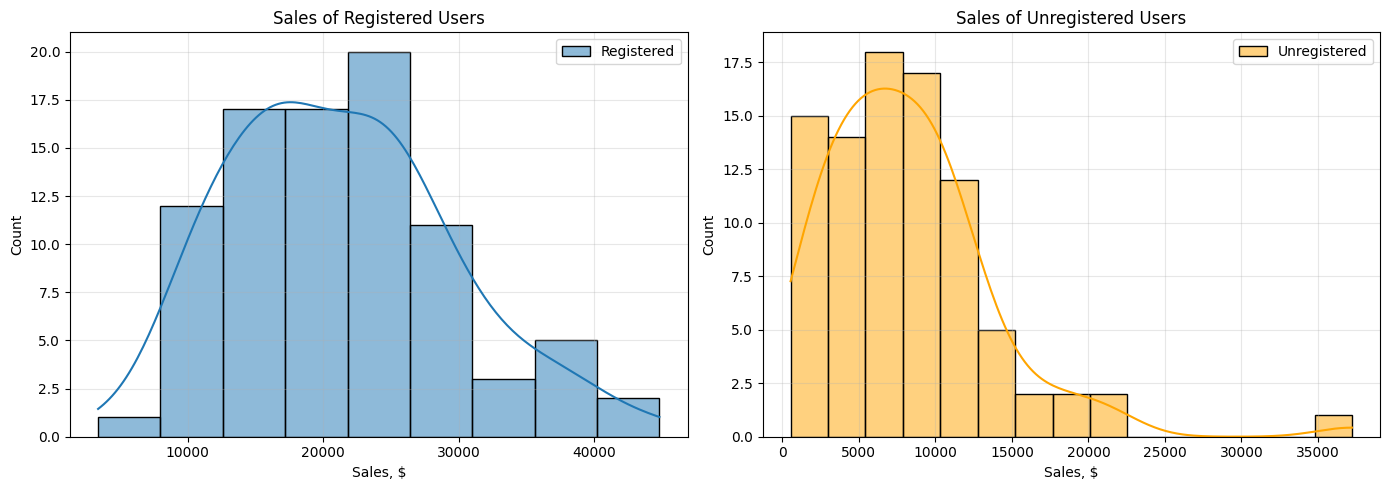

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(registered_sales["product_price"], kde=True, ax=axes[0], label="Registered")
axes[0].set_title("Sales of Registered Users")
axes[0].set_xlabel("Sales, $")
axes[0].grid(alpha=0.3)
axes[0].legend()

sns.histplot(unregistered_sales["product_price"], color="orange", kde=True,  ax=axes[1], label="Unregistered")
axes[1].set_title("Sales of Unregistered Users")
axes[1].set_xlabel("Sales, $")
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [54]:
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

# Тест Шапиро

shapiro_registered = shapiro(registered_sales["product_price"])
shapiro_unregistered = shapiro(unregistered_sales["product_price"])
print(f"""Shapiro Registered: p = {shapiro_registered.pvalue:.4f}
Shapiro Unregistered: p = {shapiro_unregistered.pvalue:.4f}""")


Shapiro Registered: p = 0.1133
Shapiro Unregistered: p = 0.0000


In [55]:
# Тест Манна–Уітні для порівняння цін на продукти між зареєстрованими та незареєстрованими користувачами

stat, p_value = mannwhitneyu(registered_sales["product_price"], unregistered_sales["product_price"])
print(f"U-statistic = {stat:.2f}, p-value = {p_value:.4f}")


U-statistic = 7147.00, p-value = 0.0000


**Висновки:**

**Зареєстровані користувачі (Registered)**:

* Розподіл більш симетричний, з центром близько 20 000 – 25 000 $.
* Ці користувачі мають стабільніші та вищі суми продажів.

**Незареєстровані користувачі (Unregistered)**:

* Розподіл скошений вправо, з піком ближче до 5 000 – 10 000 $.
* Більшість продажів незареєстрованих користувачів невеликі, разові покупки.

Значення тестової статистики Манна–Уітні:
* U-статистика = 7147
* p-value = 0.0000 (p < 0.05)

Отже відхиляємо нульову гіпотезу, що розподіли продажів однаковий.

Продажі у зареєстрованих і незареєстрованих користувачів значущо відрізняються.

## **Analytical dashboard**

**[Tableau Dashboard](https://public.tableau.com/app/profile/daria.sazon/viz/SalesDA/Dashboard1?publish=yes)**